In [25]:
import pandas as pd
import seaborn as sns
from lib.constants import AMINO_ACID_CODE_NAMES
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv('search/win2.csv')
df['seq'] = df.seq.apply(lambda x: x.split('_')[1])
df = df.sort_values('n_matches', ascending=False)
df.to_csv('search/win2_sorted.csv', index=False)

Text(0.5, 1.0, 'Number of matches for all possible 2mers')

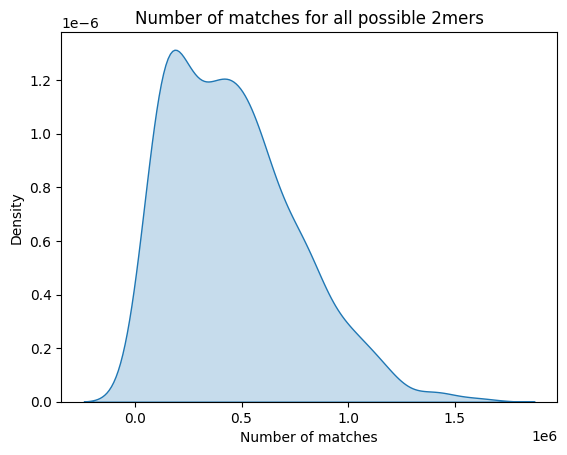

In [35]:
fig, ax = plt.subplots()
sns.kdeplot(data=df, x='n_matches', fill=True, ax=ax)
ax.set_xlabel('Number of matches')
ax.set_title('Number of matches for all possible 2mers')